In [18]:
import pandas as pd
import cvxpy as cp
import mosek
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
import random
from scipy.integrate import cumtrapz

# version_11/09

# TODO

1. expand the platoon optimization to take the powertrain/actuation delay $\tau$ into consideration
2. implement car following model as an additonal controller to smooth out the vehicle trajectory
3. test different configuration of the parameters pairs
    - longer block, longer red duration, vehicle following constraints
4. using fixed seeds, randomize block length/red duration in attempt to disturb the vehicle trajectory
5. further improve the relation between following distance, H, and Fdrag fraction

# Constants

## Powertrain and traffic light constants

In [231]:
# powertrain constant to define

## Shared across platforms

m = 1611+82             # average vehicle mass + driver [kg]
rho = 1.225             # air density [kg/m^3]
Cd = 0.23               # drag coefficient
Aref = 2.22             # average vehicle frontal area [m^2]
g = 9.81                # gravity constant [m/s^2]
Crr = 0.01              # rolling resistance coefficient
Cv = 0.3                # kinetic friction coefficient
r = 0.334               # wheel radius [m] (235/45R18 tire)

## ICE only (Honda Civic 2012 5AT)
f_ice = 0.375           # idle fuel consumption [ml/s]
P_max = 104.398         # max engine power [kw]
P_min = 0               # min engine power [kw]
wp_max = 6500           # engine angular speed at max power [rpm]
wt_max = 4300           # engine angular speed at max torque [rpm]
gear = [2.666, 1.534, 1.022, 0.721, 0.525, 4.44] # gear ratio
cor_v = [0, 7.5, 11.4, 16, 22] # corresponding velocity for each gear(ex: gear 1 ratio = 2.666,cor_v = 0~7.5) [m/s]

## EV only
# f_ev =                # idle energy consumption[kW]
capacity_kWh = 54       # [kWh]
Voc = 360               # [V]
Pmax_kW = 211           # [kW]
Tmax_Nm = 375           # [Nm]
Tmax_rpm = 4000         # [rpm] max motor speed at max torque
gear_ratio = 9          # motor to driven axle gear ratio
max_speed = 16000       # [rpm] maximum motor speed
dt_eff = 0.85           # drivetrain efficiency
Rcirc = 0.05            # [Ohms]

# constraint constants to define

pos_final = 3000        # corridor horizon [m]
N = 380                 # time horizon [sec]
vel_lower = 0           # velocity lower bound [m/s]
vel_upper = 17.5        # velocity upper bound [m/s]
acc_abs = 1.5           # accel upper bound [m/s^2]
jerk_abs = 1            # jerk (derivative of acceleration) upper bound [m/s^3]
lin_drag = 10           # linearize drag about this speed

# Traffic light constraints
# Define a traffic light as [initial time, final time, position]

redlight = 30 # redlight duration [sec]
greenlight = 50 # greenlight duration [sec]
block = 250 # length of one block [m]

N = 380 # minimum time is N~=pos_final/10*0.9
dt = 1
M = 1e5

## Platoon constants

In [232]:
# platoon constants

# to reduce the complexity of the problem and avoid the case and optimal solution of 
# platoon breaking apart, we manually reduce the number of red periods which allows more 
# space and time for the entire platoon to traverse through the cooridor in a green wave with 
# a relative sub-optimal control scheme

L = 15.5 # vehicle length [ft] - source: ?
tau = 0.2 # drivetrain actuation delay [s] - source: alben's lacc code
drag_frac = [1, 0.85, 0.78] # fraction of drag experience by the 2nd and 3rd platoon vehicle 

# [lead, middle, trail], ignore G since our bounds on vehicle following distance is much tighter
ldv_a = [-0.8906, -1.6679, 1.0185]
ldv_b = [-0.8985, -0.5126, 1.1393]
ldv_c = [-0.5953, -0.1197, 1.1393]

num_veh = 3 # number of vehicles in the platoon
d_min = 20 # minimum following distance [ft]
d_max = 100 # maximum following distance [ft]

# convert from [ft] to [m]
L = L * 0.3048
d_min = d_min * 0.3048
d_max = d_max * 0.3048

# Platoon Optimization Formulation

In [250]:
# def pltn_optimizer_setup(num_red=num_red, L=L, tau=tau, drag_frac=drag_frac):
    
    
# Define optimization vars, this time for all vehicles in the platoon

H = cp.Variable((num_veh-1, N)) # Headway between platoon vehicles [s]

x1 = cp.Variable((num_veh, N+1)) # Position
x2 = cp.Variable((num_veh, N+1)) # Velocity
T = cp.Variable((num_veh, N)) # Powertrain torque
Fdrag = cp.Variable((num_veh, N)) # Vehicle drag
E = cp.Variable((num_veh, N+1)) # Battery energy
Pmot = cp.Variable((num_veh, N)) # Battery power
Vcirc = cp.Variable((num_veh, N)) # Circuit voltage
I = cp.Variable((num_veh, N)) # Motor current
SOC = cp.Variable((num_veh, N+1)) # Battery SOC
pedal = cp.Variable((num_veh, N), integer=True)

# Define objective function, for the platoon

objective = cp.Minimize( cp.sum([E[veh][0]-E[veh][N] for veh in np.arange(num_veh)]) ); title = 'Minimum Energy' # Minimum energy


# Define a traffic light as [initial time, final time, position]

# random.seed(10)
# rand_block_ext = random.randint(50, 100)

tls_bools = {}
tls_on = True # Control whether or not traffic lights are used

tls = []
for intersection in np.arange(0, pos_final, block):

    for start in np.arange(10, N*dt, redlight + greenlight):
        tls.append([start, start + redlight, intersection]) # + random.randint(-5, 5)

# Define constraints
constraints = [ ]

# The for loop below will automatically create constraints for all traffic lights
for veh in np.arange(num_veh):

    ## initial conditions

    # pos_init[0] = 0 m
    # pos_init[1] = - (L + h_min*vel_upper) m
    # pos_init[2] = - (2L + 2*h_min*vel_upper) m

    #constraints += [ x1[veh][0] == -1*(veh*L + veh*d_min) ] # negative initial position
    constraints += [ x1[veh][0] == (num_veh-1)*(L + d_min) - veh*(L + d_min) ]
    constraints += [ x1[veh][N] == pos_final - veh*(L + d_min) ]

    constraints += [ x2[veh][0] == 0 ] # vel_init = 0 m/s
    constraints += [ x2[veh][N] == 0 ] # vel_final = 0 m/s

    constraints += [ x2[veh][1] == x2[veh][0] ] # # acc_init = 0 m/s^2
    constraints += [ x2[veh][N] == x2[veh][N-1] ] # acc_final = 0 m/s^2

    ## Traffic light constraints

    for i in range(len(tls)):
        # Ensure that traffic light fits into optimization horizon
        if int(tls[i][0]/dt) <= N and tls_on:            
            dict_index = "tl{0}".format(i)
            tls_bools[dict_index] = cp.Variable(1, boolean=True)
            # Clip end of traffic light if it goes past optimization horizon
            t_initial = int(tls[i][0]/dt)
            if int(tls[i][1]/dt) > N:
                t_final = N
            else:
                t_final = int(tls[i][1]/dt)
            position = tls[i][2]

            constraints += [ x1[veh][t_final]   - position <=  M*tls_bools[dict_index] ]
            constraints += [ x1[veh][t_initial] - position >= -M*(1-tls_bools[dict_index]) ]

    for k in range(0, N):

        # vel_lower >= 0 m/s
        constraints += [ x2[veh][k+1] >= vel_lower ]
        # vel_lower <= 15 m/s (~55 km/hr)
        constraints += [ x2[veh][k+1] <= vel_upper ]
        # acc_lower >= -3 m/s^2
        constraints += [ (x2[veh][k+1] - x2[veh][k])/dt >= -acc_abs ]
        # acc_upper <= 3 m/s^2
        constraints += [ (x2[veh][k+1] - x2[veh][k])/dt <= acc_abs ]
        constraints += [ x1[veh][k+1] == x1[veh][k] + x2[veh][k]*dt ]
        constraints += [ x2[veh][k+1] == x2[veh][k] + ( (T[veh][k])/m/r*gear_ratio*dt_eff - Fdrag[veh][k]/m )*dt ]
        
        
        f_drag = 0.5*rho*Cd*Aref*x2[veh][k]**2 + Cv*x2[veh][k] + Crr*m*g*pedal[veh][k]
    
        """
        # a*G ^ b + c
        if veh == 0:
            drag_frac = 1
        elif veh == 1:
            drag_frac = cp.power(ldv_a[1]*( x1[veh-1][k] - L - x1[veh][k] ), ldv_b[1]) + ldv_c[1]
        elif veh == 2:
            drag_frac = cp.power(ldv_a[2]*( x1[veh-1][k] - L - x1[veh][k] ), ldv_b[2]) + ldv_c[2]
        """
        
        constraints += [ Fdrag[veh][k] >=  f_drag*drag_frac[veh]]
        constraints += [ E[veh][k+1] == E[veh][k] - Voc*Vcirc[veh][k]/Rcirc*dt/3600 ]
        constraints += [ x2[veh][k]*60/(2*np.pi*r)*gear_ratio <= max_speed ]
        constraints += [ T[veh][k] <= Tmax_Nm/(max_speed-Tmax_rpm)*max_speed + (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[veh][k]*60/(2*np.pi*r)*gear_ratio ]
        constraints += [ T[veh][k] >= - Tmax_Nm/(max_speed-Tmax_rpm)*max_speed - (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[veh][k]*60/(2*np.pi*r)*gear_ratio ]
        constraints += [ x1[veh][k] >= (pos_final - veh*(L + d_min))*(1-pedal[veh][k]) ]

    for k in range(1, N):
        # Minimize jerk (derivative of acceleration)
        constraints += [ (x2[veh][k+1] - 2*x2[veh][k] + x2[veh][k-1])/dt**2 <= jerk_abs ]
        constraints += [ (x2[veh][k+1] - 2*x2[veh][k] + x2[veh][k-1])/dt**2 >= -jerk_abs ]

    
    # Pedal
    constraints += [ pedal[veh] <= 1]
    constraints += [ pedal[veh] >= 0]
    # SOC
    constraints += [ SOC[veh][0] == 0.8 ]
    constraints += [ SOC[veh] == E[veh]/capacity_kWh/1000]
    constraints += [ SOC[veh] <= 0.8 ]
    constraints += [ SOC[veh] >= 0.2 ]
    # Power
    constraints += [ Pmot[veh] <= Vcirc[veh]/Rcirc*Voc - (Vcirc[veh])**2/Rcirc ] # Relaxed SOC constraint --> Becomes tight to minimize energy loss
    constraints += [ T[veh] <= Tmax_Nm ]
    constraints += [ T[veh] >= -Tmax_Nm ]
    constraints += [ T[veh] == Pmot[veh]/(Pmax_kW*1000)*Tmax_Nm ]
    # Voc
    constraints += [ Vcirc[veh]/Rcirc <= (Pmax_kW*1000)/Voc ] # Current limit

    #return objective, constraints

for gap_index in np.arange(num_veh-1):
    for k in np.arange(N):

        front_veh = gap_index
        follow_veh = gap_index + 1

        constraints += [ H[gap_index][k] == x1[front_veh][k] - L - x1[follow_veh][k] ]
        #constraints += [ H[veh_index][k] >= h_min*(pedal[veh][k]) ]
        #constraints += [ H[veh_index][k] <= h_max ]
    
    # Defining veh Following Distance
    # 0, 1, 2
    # leading, car2, car3
    
    # Following Distance
    constraints += [ H[gap_index] >= d_min ]
    constraints += [ H[gap_index] <= d_max ]


## Solve
- Intel i7 8700k = 255.99s
- Speed largely depend on pos_final and interval/block length between the traffic lights

In [252]:
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True, 
           solver='MOSEK')
print(prob.status)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 36864           
  Cones                  : 2280            
  Scalar variables       : 20332           
  Matrix variables       : 0               
  Integer variables      : 1320            

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 1.97
Presolved problem: 11790 variables, 13577 constraints, 35461 non-zeros
Presolved problem: 0 general integer, 429 binary, 11361 continuous
Clique table size: 25
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        2        1        0        NA                   9.6050249402e+02     NA          2.8   
0        2        1        0        1.0249360219e+03     9.6050249402e+02     6.29        4.6   
0        2        1        0        1.0249282628

## Plots

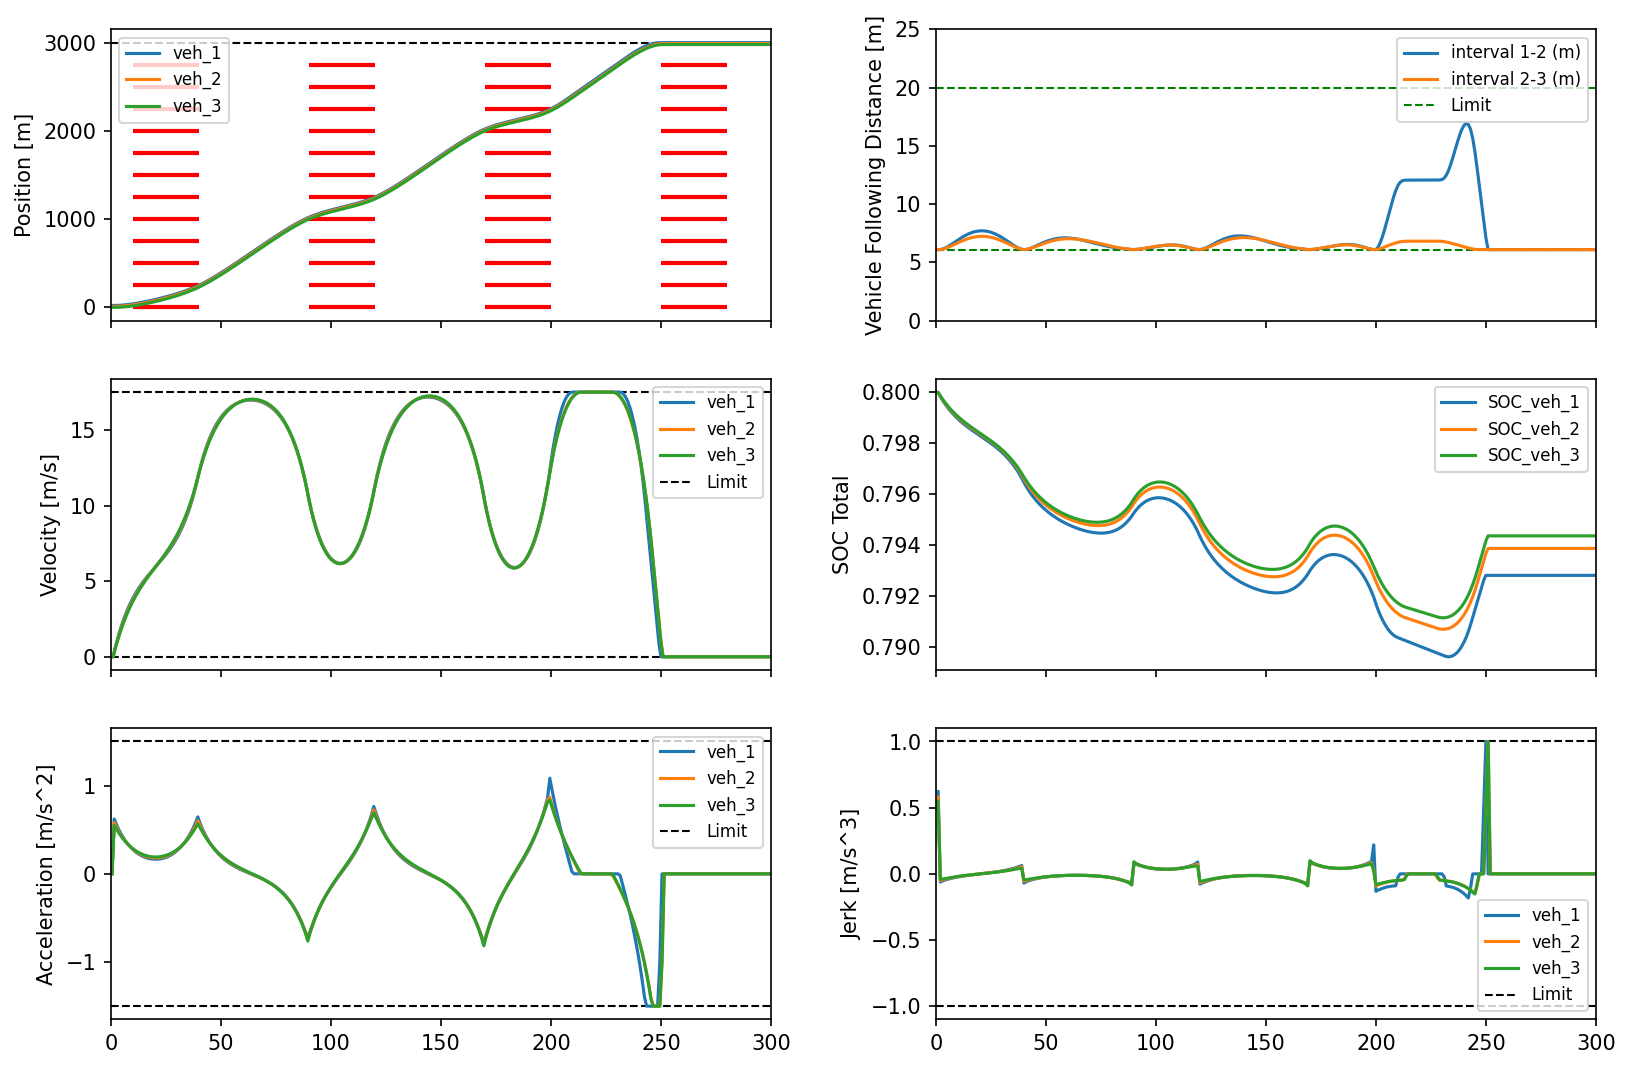

In [271]:
time = np.arange(0, (N+1)*dt, dt)
fig, axs = plt.subplots(3, 2, figsize=(12,8), sharex=True)
axs = axs.flatten()

font_size = 8
# Plot order
plt_pos = 0
plt_h = 1
plt_vel = 2
plt_soc = 3
plt_acc = 4
plt_jerk = 5


for i in range(len(tls)):
    if int(tls[i][plt_pos]/dt) <= N:
        axs[plt_pos].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')
        
for veh in np.arange(num_veh):
    veh_label = str(veh+1)
    axs[plt_pos].plot(time, x1.value[veh], label=f'veh_{veh_label}')
    axs[plt_acc].plot((time[1:]+time[:-1])/2, (x2.value[veh][1:]-x2.value[veh][:-1])/dt, label=f'veh_{veh_label}')
    axs[plt_vel].plot(time, x2.value[veh], label=f'veh_{veh_label}')
    axs[plt_soc].plot(time, SOC.value[veh], label=f'SOC_veh_{veh_label}')
    axs[plt_jerk].plot((time[2:]+time[:-2])/2, (x2.value[veh][2:]-2*x2.value[veh][1:-1]+x2.value[veh][:-2])/dt**2, label=f'veh_{veh_label}')

for veh in np.arange(num_veh-1):
    axs[plt_h].plot(time[:-1], H[veh].value, label=f'interval {veh+1}-{veh+2} (m)')
    
axs[plt_pos].legend(fontsize=font_size)
axs[plt_pos].hlines(y=pos_final, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Destination')
axs[plt_pos].set_ylabel('Position [m]')

axs[plt_h].set_ylim([0, 25])
axs[plt_h].hlines(y=20, xmin=0, xmax=int(N*dt), color='g', linestyle='--', linewidth=1, label='Limit')
axs[plt_h].hlines(y=d_min, xmin=0, xmax=int(N*dt), color='g', linestyle='--', linewidth=1)
axs[plt_h].set_ylabel('Vehicle Following Distance [m]')

axs[plt_vel].hlines(y=vel_lower, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_vel].hlines(y=vel_upper, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_vel].legend(loc='upper right', fontsize=font_size)
axs[plt_vel].set_ylabel('Velocity [m/s]')

axs[plt_soc].set_ylabel('SOC Total')
axs[plt_soc].legend(fontsize=font_size)
axs[plt_soc].yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.3f}'))

axs[plt_acc].hlines(y=-acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_acc].hlines(y=acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_acc].legend(loc='upper right', fontsize=font_size)
axs[plt_acc].set_ylabel('Acceleration [m/s^2]')

axs[plt_jerk].hlines(y=-jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_jerk].hlines(y=jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_jerk].legend(loc='lower right', fontsize=font_size)
axs[plt_jerk].set_ylabel('Jerk [m/s^3]')


axs[0].set_xlim([0, 300])
axs[1].set_xlim([0, 300])
axs[1].legend(fontsize=font_size)

plt.tight_layout()
plt.subplots_adjust(left  = 0.0875, right = 0.9125, bottom = 0.0875, top = 0.9125, wspace = 0.25, hspace = 0.2)
plt.show()

### Zoom for vehicle trajectory

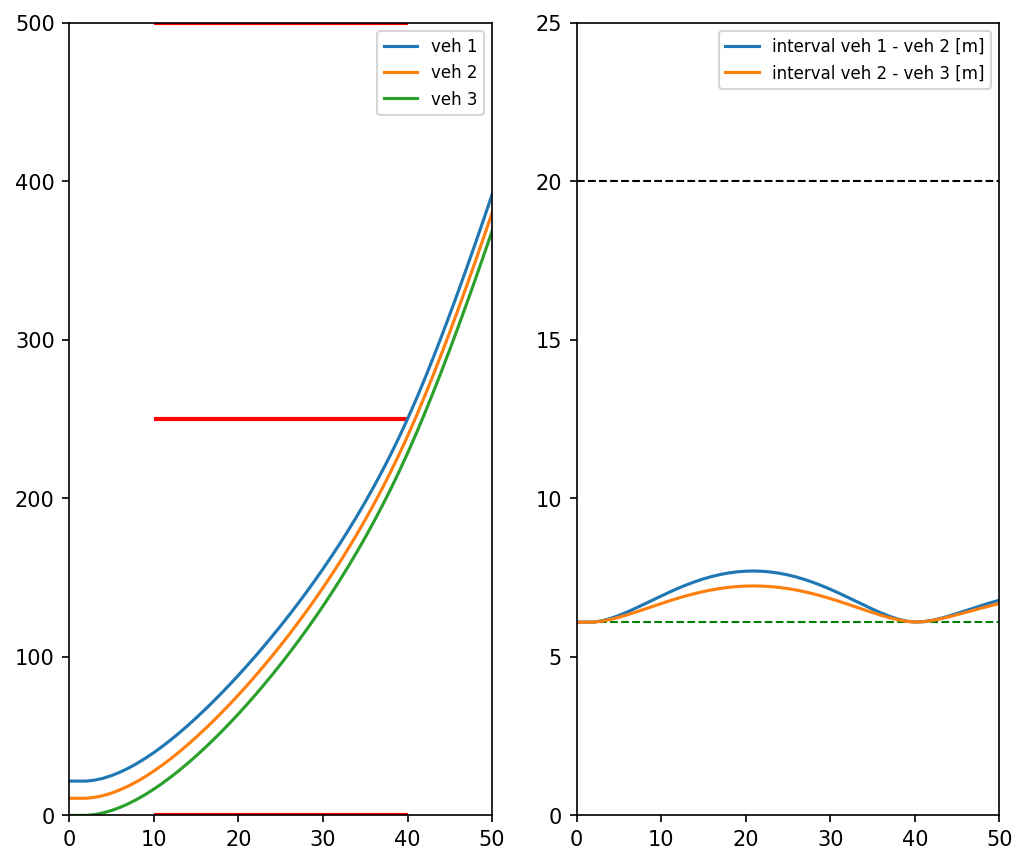

In [256]:
time = np.arange(0, (N+1)*dt, dt)
font_size = 8

fig, axs = plt.subplots(1, 2, figsize=(8, 7))

for i in range(len(tls)):
    if int(tls[i][plt_pos]/dt) <= N:
        axs[plt_pos].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')
        
axs[0].plot(time, x1.value[0], label='veh 1')
axs[0].plot(time, x1.value[1], label='veh 2')
axs[0].plot(time, x1.value[2], label='veh 3')
axs[0].legend(fontsize=font_size)

axs[1].plot(time[:-1], H[0].value, label='interval veh 1 - veh 2 [m]')
axs[1].plot(time[:-1], H[1].value, label='interval veh 2 - veh 3 [m]')
axs[1].set_ylim([0, 25])
axs[1].hlines(y=20, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[1].hlines(y=d_min, xmin=0, xmax=int(N*dt), color='g', linestyle='--', linewidth=1)

axs[0].set_xlim([0, 50])
axs[0].set_ylim([0, 500])
axs[1].set_xlim([0, 50])
axs[1].legend(fontsize=font_size)